# Converting XML files to CSV 

In [3]:
import pandas as pd
import numpy as np
from xml.etree import cElementTree as ElementTree
import xml.etree.ElementTree as et
from tqdm import tqdm
import logging
import re
import requests
#exec(requests.get('https://raw.githubusercontent.com/ma-ji/npo_classifier/master/API/npoclass.py').text)

logging.basicConfig(format='%(asctime)s: %(message)s', filename='analysis.log', level=logging.DEBUG)

## Convert XML files to Python Dictionaries 

In [32]:
class XmlListConfig(list):
    def __init__(self, aList):
        for element in aList:
            if element:
                # treat like dict
                if len(element) == 1 or element[0].tag != element[1].tag:
                    self.append(XmlDictConfig(element))
                # treat like list
                elif element[0].tag == element[1].tag:
                    self.append(XmlListConfig(element))
            elif element.text:
                text = element.text.strip()
                if text:
                    self.append(text)


class XmlDictConfig(dict):
    '''
    Example usage:

    >>> tree = ElementTree.parse('your_file.xml')
    >>> root = tree.getroot()
    >>> xmldict = XmlDictConfig(root)

    Or, if you want to use an XML string:

    >>> root = ElementTree.XML(xml_string)
    >>> xmldict = XmlDictConfig(root)

    And then use xmldict for what it is... a dict.
    '''
    def __init__(self, parent_element):
        if parent_element.items():
            self.update(dict(parent_element.items()))
        for element in parent_element:
            if element:
                # treat like dict - we assume that if the first two tags
                # in a series are different, then they are all different.
                if len(element) == 1 or element[0].tag != element[1].tag:
                    aDict = XmlDictConfig(element)
                # treat like list - we assume that if the first two tags
                # in a series are the same, then the rest are the same.
                else:
                    # here, we put the list in dictionary; the key is the
                    # tag name the list elements all share in common, and
                    # the value is the list itself 
                    aDict = {element[0].tag: XmlListConfig(element)}
                # if the tag has attributes, add those to the dict
                if element.items():
                    aDict.update(dict(element.items()))
                self.update({element.tag: aDict})
            # this assumes that if you've got an attribute in a tag,
            # you won't be having any text. This may or may not be a 
            # good idea -- time will tell. It works for the way we are
            # currently doing XML configuration files...
            elif element.items():
                self.update({element.tag: dict(element.items())})
            # finally, if there are no child tags and no attributes, extract
            # the text
            else:
                self.update({element.tag: element.text})

def get_field(xmldict, path=None, default=None):
    if path is None: return xmldict
    try:
        for p in path:
            # Ugly namespaces are ugly, let's deal with them here
            xmldict = xmldict['{http://www.irs.gov/efile}' + p]
        return xmldict
    except KeyError:
        # If this key does not exist in the dictionary, 
        return default
        # Note: it may be faster to check ```if p not in dict``` rather
        # than set up this try/except block. I think it depends on how
        # often this fails - the more it fails, the worse the try/except does.

In [5]:
tree = et.parse('data/test/201722789349300037_public.xml')
root = tree.getroot()
root

<Element '{http://www.irs.gov/efile}Return' at 0x000002660A022630>

## Analysis

### Analyze one file

This function returns a `1 x n` DataFrame of all relevant data for a single file, which can be appended to a larger DataFrame for multi-file analysis.

In [33]:
def analyze_one(path):
    object_id = re.sub("\D", "", path)
    object_list = [[object_id]]
    object_df = pd.DataFrame(object_list, columns =['Object_ID'])
    tree = et.parse(path)
    root = tree.getroot()
    #Converting from xml to dictionary
    xmldict = XmlDictConfig(root)

    
    ##############Header Information 
    #Date Information
    tax_period_begin = get_field(xmldict, ['ReturnHeader','TaxPeriodBeginDt'])
    
    #Filer Information
    filer_data = get_field(xmldict, ['ReturnHeader', 'Filer'], {})
    ein = get_field(filer_data, ['EIN'])
    business_name = get_field(filer_data, ['BusinessName', 'BusinessNameLine1Txt'])
    city = get_field(filer_data, ['USAddress', 'CityNm'])
    state = get_field(filer_data, ['USAddress', 'StateAbbreviationCd'])
    zipc = get_field(filer_data, ['USAddress', 'ZIPCd'])
    tax_year = get_field(xmldict, ['ReturnHeader', 'TaxYr'])
    filer_list = [[tax_year, tax_period_begin, ein, business_name, city, state, zipc]]
    filer_df = pd.DataFrame(filer_list, columns = ['TaxYr','TaxPeriodBeginDt','EIN', 'BusinessName', 'City', 'State', 'ZIPCd']) 
    
    
    ##############Return Data
    return_data = get_field(xmldict, ['ReturnData', 'IRS990'])
    if return_data is None:
        logging.warning(f'Could not find Return Data for file: {path}')
        return None
    
    #Formation Year
    formation_year = get_field(return_data, ['FormationYr'], "NA")
    
    #State of legal domicile 
    legal_dom = get_field(return_data, ['LegalDomicileStateCd'], "NA")
    
    #Related Org
    related = get_field(return_data, ['RelatedOrganizationsAmt'], 0)

    #GovernmentGrantsAmt
    gov_grants = get_field(return_data, ['GovernmentGrantsAmt'], 0)

    #FederatedCampaignsAmt
    fed_camp = get_field(return_data, ['FederatedCampaignsAmt'], 0)

    #MembershipDuesAmt
    membership = get_field(return_data, ['MembershipDuesAmt'], 0)

    #FundraisingAmt
    fundraising = get_field(return_data, ['FundraisingAmt'], 0)
    
    #NoncashContributionsAmt
    NoncashContributionsAmt = get_field(return_data, ['NoncashContributionsAmt'], 0)
    
    #AllOtherContributionsAmt
    all_other = get_field(return_data, ['AllOtherContributionsAmt'], 0)

    #TotalContributionsAmt
    total_contri = get_field(return_data, ['TotalContributionsAmt'], 0)
    
    #TotalProgramServiceRevenueAmt
    program_service_rev = get_field(return_data, ['TotalProgramServiceRevenueAmt'], 0)
    
    #CYInvestmentIncomeAmt
    CY_investment_income = get_field(return_data, ['CYInvestmentIncomeAmt'], 0)
    
    #CYOtherRevenueAmt
    CYOtherRevenueAmt = get_field(return_data, ['CYOtherRevenueAmt'], 0)
    
    #CYTotalRevenueAmt
    CYTotalRevenueAmt = get_field(return_data, ['CYTotalRevenueAmt'], 0)
    
    #CYTotalExpensesAmt
    CYTotalExpensesAmt = get_field(return_data, ['CYTotalExpensesAmt'], 0)
    
    #TotalFunctionalExpensesGrp, ProgramServicesAmt
    TotalFunctionExpenses_ProgramServicesAmt = get_field(return_data, ['TotalFunctionalExpensesGrp', 'ProgramServicesAmt'], 0)
    
    #TotalFunctionalExpensesGrp, ManagementAndGeneralAmt
    TotalFunctionExpenses_ManagementAndGeneralAmt = get_field(return_data, ['TotalFunctionalExpensesGrp', 'ManagementAndGeneralAmt'], 0)
    
    #TotalFunctionalExpensesGrp,FundraisingAmt
    TotalFunctionExpenses_FundraisingAmt = get_field(return_data, ['TotalFunctionalExpensesGrp', 'FundraisingAmt'], 0)
    
    #CYRevenuesLessExpensesAmt
    CYRevenuesLessExpensesAmt = get_field(return_data, ['CYRevenuesLessExpensesAmt'], 0)
    
    #TotalAssetsEOYAmt
    TotalAssetsEOYAmt = get_field(return_data, ['TotalAssetsEOYAmt'], 0)
    
    #TotalLiabilitiesEOYAmt
    TotalLiabilitiesEOYAmt = get_field(return_data, ['TotalLiabilitiesEOYAmt'], 0)
    
    #NetAssetsOrFundBalancesEOYAmt
    NetAssetsOrFundBalancesEOYAmt = get_field(return_data, ['NetAssetsOrFundBalancesEOYAmt'], 0)

    #ActivityOrMissionDesc
    ActivityOrMissionDesc = get_field(return_data, ['ActivityOrMissionDesc'], "")
    
    #MissionDesc
    descri = get_field(return_data, ['MissionDesc'], "")

    #TypeOfOrganizationCorpInd
    corp_ind = get_field(return_data, ['TypeOfOrganizationCorpInd'], "NA")
    
    #Trust
    TypeOfOrganizationTrustInd = get_field(return_data, ['TypeOfOrganizationTrustInd'], "NA")
    
    #asso
    TypeOfOrganizationAssocInd = get_field(return_data, ['TypeOfOrganizationAssocInd'], "NA")
    
    #other
    TypeOfOrganizationOtherInd = get_field(return_data, ['TypeOfOrganizationOtherInd'], "NA")
    
    #SchoolOperatingInd
    SchoolOperatingInd = get_field(return_data, ['SchoolOperatingInd'], "NA")
    
    #OperateHospitalInd
    OperateHospitalInd = get_field(return_data, ['OperateHospitalInd'], "NA") #Sometimes has {'referenceDocumentId': 'IRS990ScheduleH'} for true 
    
    #AddressChangeInd
    AddressChangeInd = get_field(return_data, ['AddressChangeInd'], "")
    
    #InitialReturnInd
    InitialReturnInd = get_field(return_data, ['InitialReturnInd'], "")
    
    #AmendedReturnInd
    AmendedReturnInd = get_field(return_data, ['AmendedReturnInd'], "")
    
    #FinalReturnInd
    FinalReturnInd = get_field(return_data, ['FinalReturnInd'], "")
    
    #TerminateOperationsInd
    TerminateOperationsInd = get_field(return_data, ['TerminateOperationsInd'], "")
    
    #ScheduleO
    schedule0 = get_field(xmldict,['ReturnData','IRS990ScheduleO'], "none")
   


    return_list = [[formation_year, legal_dom, related, gov_grants,fed_camp,membership,fundraising, NoncashContributionsAmt,all_other, total_contri,
                          program_service_rev, CY_investment_income,CYOtherRevenueAmt, CYTotalRevenueAmt,CYTotalExpensesAmt,
                            TotalFunctionExpenses_ProgramServicesAmt, TotalFunctionExpenses_ManagementAndGeneralAmt,TotalFunctionExpenses_FundraisingAmt,
                    CYRevenuesLessExpensesAmt,
                          TotalAssetsEOYAmt,TotalLiabilitiesEOYAmt,NetAssetsOrFundBalancesEOYAmt,ActivityOrMissionDesc, descri, corp_ind,
                        TypeOfOrganizationTrustInd, TypeOfOrganizationAssocInd, TypeOfOrganizationOtherInd, SchoolOperatingInd, OperateHospitalInd,
                         AddressChangeInd, InitialReturnInd,AmendedReturnInd, FinalReturnInd, TerminateOperationsInd,schedule0]]
    
    return_df = pd.DataFrame(return_list, columns = ['FormationYr', 'LegalDomicileStateCd','RelatedOrganizationsAmt','GovernmentGrantsAmt',
                                                                 'FederatedCampaignsAmt','MembershipDuesAmt','FundraisingAmt','NoncashContributionsAmt',
                                                                 'AllOtherContributionsAmt','TotalContributionsAmt','TotalProgramServiceRevenueAmt','CYInvestmentIncomeAmt',
                                                                 'CYOtherRevenueAmt','CYTotalRevenueAmt','CYTotalExpensesAmt',
                                                                 'TotalFunctionExpenses_ProgramServicesAmt', 'TotalFunctionExpenses_ManagementAndGeneralAmt',
                                                                 'TotalFunctionExpenses_FundraisingAmt',
                                                                 'CYRevenuesLessExpensesAmt','TotalAssetsEOYAmt',
                                                                 'TotalLiabilitiesEOYAmt','NetAssetsOrFundBalancesEOYAmt',
                                                                 'ActivityOrMissionDesc','MissionDesc','TypeOfOrganizationCorpInd','TypeOfOrganizationTrustInd','TypeOfOrganizationAssocInd',
                                                                 'TypeOfOrganizationOtherInd','SchoolOperatingInd',
                                                                 'OperateHospitalInd','AddressChangeInd', 'InitialReturnInd','AmendedReturnInd',
                                                                 'FinalReturnInd','TerminateOperationsInd', 'schedule0'])
    ##############Schedule O
    #scheduleodesc = get_field(xmldict, ['ReturnData','ScheduleO'])
    
    #FORM 990, PART VI, SECTION B, LINE 11B
    #Form 990, Part III, Line 1
    
    #Concatenating header information and contributions
    return pd.concat([object_df, filer_df, return_df], axis=1, ignore_index=False)
    

### Example Analysis


In [4]:
df = pd.DataFrame([])
pd.options.display.max_columns = None

one_row = analyze_one('C:/Users/Administrator/Desktop/irs_2018/201800089349300945_public.xml')
df = df.append(one_row) 
df

,Object_ID,TaxYr,TaxPeriodBeginDt,EIN,BusinessName,City,State,ZIPCd,FormationYr,LegalDomicileStateCd,RelatedOrganizationsAmt,GovernmentGrantsAmt,FederatedCampaignsAmt,MembershipDuesAmt,FundraisingAmt,NoncashContributionsAmt,AllOtherContributionsAmt,TotalContributionsAmt,TotalProgramServiceRevenueAmt,CYInvestmentIncomeAmt,CYOtherRevenueAmt,CYTotalRevenueAmt,CYTotalExpensesAmt,TotalFunctionExpenses_ProgramServicesAmt,TotalFunctionExpenses_ManagementAndGeneralAmt,CYRevenuesLessExpensesAmt,TotalAssetsEOYAmt,TotalLiabilitiesEOYAmt,NetAssetsOrFundBalancesEOYAmt,ActivityOrMissionDesc,MissionDesc,TypeOfOrganizationCorpInd,TypeOfOrganizationTrustInd,TypeOfOrganizationAssocInd,TypeOfOrganizationOtherInd,SchoolOperatingInd,OperateHospitalInd,AddressChangeInd,InitialReturnInd,AmendedReturnInd,FinalReturnInd,TerminateOperationsInd,schedule0
0,2018201800089349300945,2015,2015-07-01,953751374,ROSECRANS MANOR,SAN DIEGO,CA,92110,1982,CA,0,65989,0,0,0,0,0,65989,728411,105,2898,797403,721235,721235,0,76168,2025169,2385035,-359866,See Schedule O,To provide low income housing for the elderly....,X,NA,NA,NA,false,false,X,,,,false,{'{http://www.irs.gov/efile}SupplementalInform...


### Get a list of files to analyze
You can generate a full index at the path used below with `extract_eins.ipynb`, or just download [this one](https://www.dropbox.com/s/237lcs9dcmqzjug/full_index.csv?dl=0) and place it in a folder called `index`. 

In [5]:
index = pd.read_csv('index/full_index.csv')
files = 'data/' + index.loc[index['TAX_YEAR'] == 2016]['OBJECT_ID'].astype('str') + '_public.xml'
files

6          data/201731359349202698_public.xml
15         data/201800529349300205_public.xml
19         data/201721359349307007_public.xml
28         data/201701869349300730_public.xml
36         data/201702209349300965_public.xml
                          ...                
3261613    data/201741309349201189_public.xml
3261621    data/201713109349302626_public.xml
3261629    data/201703189349103250_public.xml
3261637    data/201841319349304634_public.xml
3261645    data/201733199349101418_public.xml
Name: OBJECT_ID, Length: 437222, dtype: object

If you do not have all of these files available, you can do the following:

1. Run `files.to_csv('index/2017.txt', header=False, index=False)` to get a list of all the files you need to download
2. Run this in powershell: `ForEach ($file in (Get-Content -Path "index/2017.txt")) {aws s3 cp ("s3://irs-form-990/"+$file) ("data/"+$file)}` 

Note: I'm not able to completely test this script without reinstalling aws so this hasn't been completely tested but it *should* work.


### Alternative using all the files in the directory 

In [35]:
#This is the method I used to get all the files in the directory

import os

'''
    For the given path, get the List of all files in the directory tree 
'''
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles


dirName = 'C:/Users/tenis/OneDrive/Desktop/impact_capital_old/data/test';
files = getListOfFiles(dirName)






In [37]:
files

['C:/Users/tenis/OneDrive/Desktop/impact_capital_old/data/test\\201602159349301240_public.xml',
 'C:/Users/tenis/OneDrive/Desktop/impact_capital_old/data/test\\201602179349301510_public.xml',
 'C:/Users/tenis/OneDrive/Desktop/impact_capital_old/data/test\\201602229349300030_public.xml',
 'C:/Users/tenis/OneDrive/Desktop/impact_capital_old/data/test\\201602359349100060_public_pf.xml',
 'C:/Users/tenis/OneDrive/Desktop/impact_capital_old/data/test\\201602359349300500_public.xml',
 'C:/Users/tenis/OneDrive/Desktop/impact_capital_old/data/test\\201731889349301203_public.xml']

### Create the dataframe with selected fields

In [36]:
df = pd.concat([one_row for name in tqdm(files) if (one_row := analyze_one(name)) is not None])
df

100%|██████████| 6/6 [00:00<00:00, 37.01it/s]


,Object_ID,TaxYr,TaxPeriodBeginDt,EIN,BusinessName,City,State,ZIPCd,FormationYr,LegalDomicileStateCd,RelatedOrganizationsAmt,GovernmentGrantsAmt,FederatedCampaignsAmt,MembershipDuesAmt,FundraisingAmt,NoncashContributionsAmt,AllOtherContributionsAmt,TotalContributionsAmt,TotalProgramServiceRevenueAmt,CYInvestmentIncomeAmt,CYOtherRevenueAmt,CYTotalRevenueAmt,CYTotalExpensesAmt,TotalFunctionExpenses_ProgramServicesAmt,TotalFunctionExpenses_ManagementAndGeneralAmt,TotalFunctionExpenses_FundraisingAmt,CYRevenuesLessExpensesAmt,TotalAssetsEOYAmt,TotalLiabilitiesEOYAmt,NetAssetsOrFundBalancesEOYAmt,ActivityOrMissionDesc,MissionDesc,TypeOfOrganizationCorpInd,TypeOfOrganizationTrustInd,TypeOfOrganizationAssocInd,TypeOfOrganizationOtherInd,SchoolOperatingInd,OperateHospitalInd,AddressChangeInd,InitialReturnInd,AmendedReturnInd,FinalReturnInd,TerminateOperationsInd,schedule0
0,201602159349301240,2015,2015-01-01,251753030,Consumer Health Coalition,Pittsburgh,PA,15212,1993,PA,0,0,0,3410,0,0,1476893,1480303,37016,389,0,1517708,1269628,1008501,171519,89608,248080,665718,16692,649026,To inspire consumer movement to enhance access...,To inspire consumer movement to enhance access...,X,NA,NA,NA,0,0,,,,,0,{'{http://www.irs.gov/efile}SupplementalInform...
0,201602179349301510,2015,2015-04-01,860902767,VALLEY OF THE SUN BOWL FOUNDATION,SCOTTSDALE,AZ,85251,2001,AZ,0,0,0,0,0,0,0,0,4397898,0,17448,4415346,4651658,4289805,361853,0,-236312,290899,16406074,-16115175,VALLEY OF THE SUN BOWL FOUNDATION IS COMMITTED...,VALLEY OF THE SUN BOWL FOUNDATION IS COMMITTED...,X,NA,NA,NA,0,0,,,,,0,{'{http://www.irs.gov/efile}SupplementalInform...
0,201602229349300030,2014,2014-10-01,621138045,BAPTIST MEMORIAL HOSPITAL- UNION CITY INC,UNION CITY,TN,382615403,1983,TN,0,0,0,0,0,0,2170,2170,42254924,24703,848690,43130487,47497087,39656809,7840278,0,-4366600,33414414,19527572,13886842,"BAPTIST MEMORIAL HOSPITAL-UNION CITY, INC. PRO...",BAPTIST MEMORIAL HOSPITAL-UNION CITY PROVIDES ...,X,NA,NA,NA,0,{'referenceDocumentId': 'RetDoc1041500001'},,,,,0,{'{http://www.irs.gov/efile}SupplementalInform...
0,201602359349300500,2014,2014-01-01,251459333,FRENCH CREEK VALLEY CONSERVANCY,MEADVILLE,PA,16335,1984,PA,0,2872,0,15699,0,0,204748,223319,0,5464,62331,291114,161617,62788,83206,15623,129497,341114,0,341114,"SEE SCHEDULE O, PART 1, LINE 1:",TO PROMOTE THE ENVIRONMENTAL INTEGRITY OF THE ...,X,NA,NA,NA,false,false,,,,,false,{'{http://www.irs.gov/efile}SupplementalInform...
0,201731889349301203,2015,2015-09-01,133344306,MAKE-A-WISH FOUNDATION OF THE HUDSON,TARRYTOWN,NY,105919998,1986,NY,0,0,5987,0,670329,212225,1842161,2518477,526,30533,-51721,2497815,2516763,2002430,175505,338828,-18948,1552917,789464,763453,SEE SCHEDULE O.,SEE SCHEDULE O,X,NA,NA,NA,0,0,,,,,0,{'{http://www.irs.gov/efile}SupplementalInform...


In [6]:
df.to_csv("C:/Users/Administrator/Desktop/Impact_Capital/data/objects/2018_objects.csv")



# Data Cleaning

In [13]:
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 1000)
pd.set_option('display.min_rows', 200)
df2016 = pd.read_csv("C:/Users/tenis/OneDrive/Desktop/Data_Projects/Impact_Capital/data/interim/2016_objects.csv")
df2017 = pd.read_csv("C:/Users/tenis/OneDrive/Desktop/Data_Projects/Impact_Capital/data/interim/2017_objects.csv")
df = pd.read_csv("C:/Users/tenis/OneDrive/Desktop/Data_Projects/Impact_Capital/data/interim/form_990_objects_2018_2020.csv")

df = df.append(df2017, ignore_index = True)
df = df.append(df2016, ignore_index = True)

#Fixing Types of Orgs 
df.loc[df['TypeOfOrganizationCorpInd'] != "X", 'TypeOfOrganizationCorpInd'] = 0
df.loc[df['TypeOfOrganizationCorpInd'] == "X", 'TypeOfOrganizationCorpInd'] = 1
df.loc[df['TypeOfOrganizationTrustInd'] != "X", 'TypeOfOrganizationTrustInd'] = 0
df.loc[df['TypeOfOrganizationTrustInd'] == "X", 'TypeOfOrganizationTrustInd'] = 1
df.loc[df['TypeOfOrganizationTrustInd'] != "X", 'TypeOfOrganizationTrustInd'] = 0
df.loc[df['TypeOfOrganizationTrustInd'] == "X", 'TypeOfOrganizationTrustInd'] = 1
df.loc[df['TypeOfOrganizationAssocInd'] != "X", 'TypeOfOrganizationAssocInd'] = 0
df.loc[df['TypeOfOrganizationAssocInd'] == "X", 'TypeOfOrganizationAssocInd'] = 1
df.loc[df['TypeOfOrganizationOtherInd'] != "X", 'TypeOfOrganizationOtherInd'] = 0
df.loc[df['TypeOfOrganizationOtherInd'] == "X", 'TypeOfOrganizationOtherInd'] = 1

#SchoolOperatingInd	OperateHospitalInd	AddressChangeInd	InitialReturnInd	AmendedReturnInd	TerminateOperationsInd
df[['SchoolOperatingInd', 'OperateHospitalInd','AddressChangeInd',
    'InitialReturnInd', 'AmendedReturnInd','FinalReturnInd','TerminateOperationsInd','TotalFunctionExpenses_FundraisingAmt']] =df[['SchoolOperatingInd', 'OperateHospitalInd','AddressChangeInd','InitialReturnInd',
                 'AmendedReturnInd','FinalReturnInd','TerminateOperationsInd', 'TotalFunctionExpenses_FundraisingAmt']].fillna(0)

df.loc[df['SchoolOperatingInd'] == 'false', 'SchoolOperatingInd'] = 0
df.loc[df['OperateHospitalInd'] == 'false', 'OperateHospitalInd'] = 0
df.loc[df['AddressChangeInd'] == 'false', 'AddressChangeInd'] = 0
df.loc[df['InitialReturnInd'] == 'false', 'InitialReturnInd'] = 0
df.loc[df['AmendedReturnInd'] == 'false', 'AmendedReturnInd'] = 0
df.loc[df['FinalReturnInd'] == 'false', 'FinalReturnInd'] = 0
df.loc[df['TerminateOperationsInd'] == 'false', 'TerminateOperationsInd'] = 0

df.loc[df['SchoolOperatingInd'] == '0', 'SchoolOperatingInd'] = 0
df.loc[df['OperateHospitalInd'] == '0', 'OperateHospitalInd'] = 0
df.loc[df['AddressChangeInd'] == '0', 'AddressChangeInd'] = 0
df.loc[df['InitialReturnInd'] == '0', 'InitialReturnInd'] = 0
df.loc[df['AmendedReturnInd'] == '0', 'AmendedReturnInd'] = 0
df.loc[df['FinalReturnInd'] == '0', 'FinalReturnInd'] = 0
df.loc[df['TerminateOperationsInd'] == '0', 'TerminateOperationsInd'] = 0

df.loc[df['SchoolOperatingInd'] != 0, 'SchoolOperatingInd'] = 1
df.loc[df['OperateHospitalInd'] != 0, 'OperateHospitalInd'] = 1
df.loc[df['AddressChangeInd'] != 0, 'AddressChangeInd'] = 1
df.loc[df['InitialReturnInd'] != 0, 'InitialReturnInd'] = 1
df.loc[df['AmendedReturnInd'] != 0, 'AmendedReturnInd'] = 1
df.loc[df['FinalReturnInd'] != 0, 'FinalReturnInd'] = 1
df.loc[df['TerminateOperationsInd'] != 0, 'TerminateOperationsInd'] = 1

#Merging the descriptions 
#The majority of the descriptions are just duplicates, so I'm deleting the ones that are exaclty the same 
#df.ActivityOrMissionDesc= df.ActivityOrMissionDesc.str.lower()
#df.MissionDesc= df.MissionDesc.str.lower()
#df.loc[df['ActivityOrMissionDesc'] ==  df['MissionDesc'], 'MissionDesc'] = ""

df = df.drop(['Unnamed: 0', 'Object_ID', 'MissionDesc', 'schedule0'], axis=1)
df



,TaxYr,TaxPeriodBeginDt,EIN,BusinessName,City,State,ZIPCd,FormationYr,LegalDomicileStateCd,RelatedOrganizationsAmt,GovernmentGrantsAmt,FederatedCampaignsAmt,MembershipDuesAmt,FundraisingAmt,NoncashContributionsAmt,AllOtherContributionsAmt,TotalContributionsAmt,TotalProgramServiceRevenueAmt,CYInvestmentIncomeAmt,CYOtherRevenueAmt,CYTotalRevenueAmt,CYTotalExpensesAmt,TotalFunctionExpenses_ProgramServicesAmt,TotalFunctionExpenses_ManagementAndGeneralAmt,CYRevenuesLessExpensesAmt,TotalAssetsEOYAmt,TotalLiabilitiesEOYAmt,NetAssetsOrFundBalancesEOYAmt,ActivityOrMissionDesc,TypeOfOrganizationCorpInd,TypeOfOrganizationTrustInd,TypeOfOrganizationAssocInd,TypeOfOrganizationOtherInd,SchoolOperatingInd,OperateHospitalInd,AddressChangeInd,InitialReturnInd,AmendedReturnInd,FinalReturnInd,TerminateOperationsInd,TotalFunctionExpenses_FundraisingAmt
0,2016,2016-07-01,204852205,OCEAN HOUSING DEVELOPMENT III INC,BAYVILLE,NJ,8721.0,2008.0,NJ,0,0,0,0,0,0,0,0,60395,25,0,60420,62669,34242,28427,-2249,757552,788010,-30458,TO PROVIDE LOW INCOME HOUSING TO DISABLED INDI...,1,0,0,0,0,0,1,0,0,0,0,0.0
1,2016,2016-08-01,930561977,United Association Local 290 Apprentice and,tualatin,OR,97062.0,1985.0,OR,0,0,0,0,0,0,0,0,5998671,105212,290555,6394438,5314324,4539476,774848,1080114,14966871,8833,14958038,SEE SHEDULE O,0,0,0,0,1,0,0,0,0,0,0,0.0
2,2016,2016-09-01,270607115,MARION CHAMBER OF COMMERCE,MARION,IA,52302.0,2009.0,IA,0,53833,0,164930,0,0,0,218763,244192,390,22744,486089,454139,186666,267473,31950,306338,7225,299113,"PROMOTE COMMUNITY, COMMERCE AND CULTURE",1,0,0,0,0,0,0,0,0,0,0,0.0
3,2016,2016-07-01,371173814,THE GLEN-ED PANTRY,EDWARDSVILLE,IL,62025.0,1993.0,IL,0,10108,365473,0,0,0,0,375581,0,650,0,376231,407285,389532,9531,-31054,730092,500,729592,"TO PROVIDE FOOD, CLOTHING AND SHELTER ASSISTAN...",1,0,0,0,0,0,0,0,0,0,0,0.0
4,2016,2016-07-01,30353976,SOUTHEAST VERMONT TRANSIT INC,WEST DOVER,VT,5356.0,1996.0,VT,0,4611669,0,0,0,0,569938,5181607,2616141,21672,143305,7962725,8206449,4825353,3381096,-243724,14019288,2399252,11620036,"SOUTHEAST VERMONT TRANSIT (""SEVT"") IS COMMITTE...",1,0,0,0,0,0,0,0,0,0,0,0.0
5,2016,2016-07-01,352205675,Chicago Citywide Literacy Coalition,Chicago,IL,60661.0,2003.0,IL,0,0,0,0,7000,0,327314,334314,0,0,2349,336663,384103,312555,48094,-47440,271373,1404,269969,THE CHICAGO CITYWIDE LITERACY COALITION HELPS ...,1,0,0,0,0,0,0,0,0,0,0,0.0
6,2016,2016-07-01,237390720,DEARBORN HOCKEY ASSOCIATION,DEARBORN,MI,48128.0,2010.0,MI,0,0,0,0,139278,0,0,139278,348909,0,0,488187,490039,418509,5190,-1852,42063,0,42063,OPERATE AN AMATEUR HOCKEY PROGRAM IN THE CITY ...,1,0,0,0,0,0,0,0,0,0,0,0.0
7,2016,2016-07-01,231289242,DRUG AND ALCOHOL REHABILITATION SERVICES,COLUMBIA,PA,17512.0,1975.0,PA,0,0,0,0,0,0,21000,21000,2974692,9662,-40475,2964879,2969476,2653180,316296,-4597,4063503,1146690,2916813,TO ASSIST IN THE DEVELOPMENT AND RENDERING OF ...,1,0,0,0,0,0,0,0,0,0,0,0.0
8,2016,2016-09-01,300708514,MY FIRST SCHOOL,FLORAL PARK,NY,11001.0,NaN,NaN,0,0,0,0,0,0,590,590,226782,40,10874,238286,236832,176862,54074,1454,193802,164270,29532,"The My First School, was established to provid...",0,0,0,0,1,0,0,0,0,0,0,0.0
9,2016,2016-09-01,541979858,MATTHEWS CENTER FOR VISUAL LEARNING,MANASSAS,VA,20109.0,2000.0,VA,0,0,0,0,7101,3593,11620,18721,2569214,-733,1147,2588349,2324407,2021933,300166,263942,853974,216477,637497,TO ENHANCING THE LIVES OF INDIVIDUALS AND FAMI...,1,0,0,0,0,0,0,0,0,0,0,0.0


### Creating ratios to measure nonprofit financial flexibility

* **Ratio of equity to total revenue** The implicit assumption is that organizations with a larger networth relative to revenue have a greater ability to replace revenue thanthose with a smaller or negative net worth. 
* **Ratio Administrative Expenses to total Expenses** Nonprofits withhigh administrative costs (relative to others in their category) are assumedto have the greatest opportunity to cut back on administrative costs without reducing programs. 

* **Low or Negative Operating Margins** A nonprofit’s operating margin is defined as its revenues less its expenditures, divided by its revenues. This shows the percentage that its net income represents of its revenues. 

* **Revenue Concentration** 

Resource Dependence Variables 
** Dependence are funding source divided by total revenue

In [14]:
df['Ratio_Equity_Revenue'] = df['NetAssetsOrFundBalancesEOYAmt']/df['CYTotalRevenueAmt']

df['Ratio_AdminExp_Exp'] = df['TotalFunctionExpenses_ManagementAndGeneralAmt']/df['CYTotalExpensesAmt']

df['Operating_Margin'] = (df['CYTotalRevenueAmt'] - df['CYTotalExpensesAmt'])/df['CYTotalRevenueAmt']

df['Revenue_Concentration'] = (df['RelatedOrganizationsAmt']/df['CYTotalRevenueAmt'])**2 + (df['GovernmentGrantsAmt']/df['CYTotalRevenueAmt'])**2 \
                               + (df['FederatedCampaignsAmt']/df['CYTotalRevenueAmt'])**2 + (df['MembershipDuesAmt']/df['CYTotalRevenueAmt'])**2 \
                               + (df['FundraisingAmt']/df['CYTotalRevenueAmt'])**2 + (df['NoncashContributionsAmt']/df['CYTotalRevenueAmt'])**2 \
                               + (df['AllOtherContributionsAmt']/df['CYTotalRevenueAmt'])**2 + (df['TotalProgramServiceRevenueAmt']/df['CYTotalRevenueAmt'])**2 \
                               + (df['CYInvestmentIncomeAmt']/df['CYTotalRevenueAmt'])**2 + (df['CYOtherRevenueAmt']/df['CYTotalRevenueAmt'])**2

#Resource Dependence measures 
df['Dependence_Grants'] = df['GovernmentGrantsAmt']/df['CYTotalRevenueAmt']
df['Dependence_Campaigns'] = df['FederatedCampaignsAmt']/df['CYTotalRevenueAmt']
df['Dependence_Memberships'] = df['MembershipDuesAmt']/df['CYTotalRevenueAmt']
df['Dependence_Fundraising'] = df['FundraisingAmt']/df['CYTotalRevenueAmt']
df['Dependence_ProgramServ'] = df['TotalProgramServiceRevenueAmt']/df['CYTotalRevenueAmt']
df['Dependence_Invest'] = df['CYInvestmentIncomeAmt']/df['CYTotalRevenueAmt']


#df['Dependence_Grants']
#df['Dependence_Campaigns']
#df['Dependence_Memberships'] 
#df['Dependence_Fundraising'] 
#df['Dependence_ProgramServ'] 
#df['Dependence_Invest'] 



### Creating financially vulerable variable 

* Reduction in the ratio of program expenses to total reveune 
* Hager, Galaskiewicz,Bielefeld, and Pins’s 1996 study found that many charities that ceased operations did so primarily for program-related reasons (suchas a reduction of donations or a decreased demand for program services). 


In [15]:
df['Ratio_ProgramExp_Rev'] = df['TotalFunctionExpenses_ProgramServicesAmt']/df['CYTotalRevenueAmt']


### Combining name and mission description so that the BERT algorithm can use it for those that don't have miss desc. 

In [16]:
df['BusinessName'].fillna("none", inplace = True) 
df['ActivityOrMissionDesc'].fillna("none", inplace = True)
df['name_mission'] = df['BusinessName'] + ". " + df['ActivityOrMissionDesc']
df2015 = df[df['TaxYr'] == 2015]
toBert = df2015[['EIN', 'BusinessName', 'name_mission']]
toBert.to_csv("C:/Users/tenis/OneDrive/Desktop/Data_Projects/Impact_Capital/data/interim/forBERT.csv")
df2015["FormationYr"].fillna(2014, inplace = True)

C:\Users\tenis\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


### Pulling 2016, 2017, and 2018 data, assigning vulnerable variable based on if ratio of program expenses decreases



In [17]:
df2015

,TaxYr,TaxPeriodBeginDt,EIN,BusinessName,City,State,ZIPCd,FormationYr,LegalDomicileStateCd,RelatedOrganizationsAmt,GovernmentGrantsAmt,FederatedCampaignsAmt,MembershipDuesAmt,FundraisingAmt,NoncashContributionsAmt,AllOtherContributionsAmt,TotalContributionsAmt,TotalProgramServiceRevenueAmt,CYInvestmentIncomeAmt,CYOtherRevenueAmt,CYTotalRevenueAmt,CYTotalExpensesAmt,TotalFunctionExpenses_ProgramServicesAmt,TotalFunctionExpenses_ManagementAndGeneralAmt,CYRevenuesLessExpensesAmt,TotalAssetsEOYAmt,TotalLiabilitiesEOYAmt,NetAssetsOrFundBalancesEOYAmt,ActivityOrMissionDesc,TypeOfOrganizationCorpInd,TypeOfOrganizationTrustInd,TypeOfOrganizationAssocInd,TypeOfOrganizationOtherInd,SchoolOperatingInd,OperateHospitalInd,AddressChangeInd,InitialReturnInd,AmendedReturnInd,FinalReturnInd,TerminateOperationsInd,TotalFunctionExpenses_FundraisingAmt,Ratio_Equity_Revenue,Ratio_AdminExp_Exp,Operating_Margin,Revenue_Concentration,Dependence_Grants,Dependence_Campaigns,Dependence_Memberships,Dependence_Fundraising,Dependence_ProgramServ,Dependence_Invest,Ratio_ProgramExp_Rev,name_mission
32,2015,2015-07-01,60363962,AMERICAN LEGION POST 91,MOOSUP,CT,6354.0,1946.0,CT,0,0,0,7411,0,0,1001300,1008711,0,246,107646,1116603,182301,182301,0,934302,1099288,0,1099288,TO HELP AND ASSIST VETERANS AND YOUTHS IN THE ...,0,0,1,0,0,0,0,0,0,0,0,0.0,0.984493,0.000000,0.836736,0.813476,0.000000,0.000000,0.006637,0.000000,0.000000,0.000220,0.163264,AMERICAN LEGION POST 91. TO HELP AND ASSIST VE...
136,2015,2015-09-08,474112110,PLAYING FIELD INC,MADISON,WI,537055124.0,2015.0,WI,0,0,0,0,0,0,172095,172095,366355,38,0,538488,492603,389844,98759,45885,67208,0,67208,"IN THE CONTEXT OF OUR SCHOOL FAMILY, WE CARE F...",1,0,0,0,0,0,0,1,0,0,0,0.0,0.124809,0.200484,0.085211,0.565000,0.000000,0.000000,0.000000,0.000000,0.680340,0.000071,0.723960,PLAYING FIELD INC. IN THE CONTEXT OF OUR SCHOO...
157,2015,2015-07-01,953751374,ROSECRANS MANOR,SAN DIEGO,CA,92110.0,1982.0,CA,0,65989,0,0,0,0,0,65989,728411,105,2898,797403,721235,721235,0,76168,2025169,2385035,-359866,See Schedule O,1,0,0,0,0,0,1,0,0,0,0,0.0,-0.451298,0.000000,0.095520,0.841306,0.082755,0.000000,0.000000,0.000000,0.913479,0.000132,0.904480,ROSECRANS MANOR. See Schedule O
162,2015,2015-01-01,221988373,POLISH CULTURAL FOUNDATION INC,CLARK,NJ,70661855.0,1973.0,NJ,0,0,0,146807,0,0,0,146807,261612,22763,260529,691711,555314,251108,304206,136397,2040863,189086,1851777,"TO PROVIDE EDUCATIONAL, CULTURAL AND CHARITABL...",1,0,0,0,0,0,0,0,0,0,0,0.0,2.677096,0.547809,0.197188,0.331031,0.000000,0.000000,0.212237,0.000000,0.378210,0.032908,0.363024,POLISH CULTURAL FOUNDATION INC. TO PROVIDE EDU...
178,2015,2015-06-01,237224835,SCHENECTADY LIGHT OPERA COMPANY INC,SCHENECTADY,NY,12301.0,1979.0,NY,0,0,0,925,1227,0,47439,49591,172808,-2202,54250,274447,245044,206503,38541,29403,1433512,434152,999360,SLOC'S PURPOSE IS TO DEVELOP AN APPRECIATION O...,1,0,0,0,0,0,0,0,1,0,0,0.0,3.641359,0.157282,0.107135,0.465518,0.000000,0.000000,0.003370,0.004471,0.629659,-0.008023,0.752433,SCHENECTADY LIGHT OPERA COMPANY INC. SLOC'S PU...
202,2015,2015-10-01,942328156,Resources for Independence Central,Fresno,CA,93703.0,1976.0,CA,0,1054907,0,0,0,0,780,1055687,326594,348,142517,1525146,1480574,904912,559414,44572,856744,67741,789003,To provide services to disabled inidividuals. ...,1,0,0,0,0,0,0,0,0,0,0,0.0,0.517329,0.377836,0.029225,0.533004,0.691676,0.000000,0.000000,0.000000,0.214139,0.000228,0.593328,Resources for Independence Central. To provide...
205,2015,2015-09-01,237124299,SPANISH PEOPLES COMMUNITY CENTER INC,LANDISVILLE,NJ,8326.0,1980.0,NJ,0,0,0,0,0,0,710842,710842,9743,7,10891,731483,846042,839931,6111,-114559,649207,106769,542438,TO PROMOTE THE UNITY OF SPANISH-SPEAKING PEOPL...,1,0,0,0,0,0,0,0,1,0,0,0.0,0.741559,0.007223,-0.156612,0.944759,0.000000,0.000000,0.000000,0.000000,0.013320,0.000010,1.148258,SPANISH PEOPLES COMMUNITY CENTER INC. TO PROMO...
270,2015,2015-01-01,463198647,BIG HEART FOUNDATION INC,CLIFTON,NJ,7013.0,2013.0,DC,0,0,0,0,0

In [30]:
BERT = pd.read_csv("C:/Users/tenis/OneDrive/Desktop/Data_Projects/Impact_Capital/data/raw/BERT_classifications2015.csv")
df2015BERT = pd.concat([df2015.reset_index(drop=True), BERT], axis=1, ignore_index=False)
print("Number of nonprofitsL: ", len(df2015BERT))
df2015BERT

Number of nonprofitsL:  233520


,TaxYr,TaxPeriodBeginDt,EIN,BusinessName,City,State,ZIPCd,FormationYr,LegalDomicileStateCd,RelatedOrganizationsAmt,GovernmentGrantsAmt,FederatedCampaignsAmt,MembershipDuesAmt,FundraisingAmt,NoncashContributionsAmt,AllOtherContributionsAmt,TotalContributionsAmt,TotalProgramServiceRevenueAmt,CYInvestmentIncomeAmt,CYOtherRevenueAmt,CYTotalRevenueAmt,CYTotalExpensesAmt,TotalFunctionExpenses_ProgramServicesAmt,TotalFunctionExpenses_ManagementAndGeneralAmt,CYRevenuesLessExpensesAmt,TotalAssetsEOYAmt,TotalLiabilitiesEOYAmt,NetAssetsOrFundBalancesEOYAmt,ActivityOrMissionDesc,TypeOfOrganizationCorpInd,TypeOfOrganizationTrustInd,TypeOfOrganizationAssocInd,TypeOfOrganizationOtherInd,SchoolOperatingInd,OperateHospitalInd,AddressChangeInd,InitialReturnInd,AmendedReturnInd,FinalReturnInd,TerminateOperationsInd,TotalFunctionExpenses_FundraisingAmt,Ratio_Equity_Revenue,Ratio_AdminExp_Exp,Operating_Margin,Revenue_Concentration,Dependence_Grants,Dependence_Campaigns,Dependence_Memberships,Dependence_Fundraising,Dependence_ProgramServ,Dependence_Invest,Ratio_ProgramExp_Rev,name_mission,Unnamed: 0,recommended,confidence,probabilities
0,2015,2015-07-01,60363962,AMERICAN LEGION POST 91,MOOSUP,CT,6354.0,1946.0,CT,0,0,0,7411,0,0,1001300,1008711,0,246,107646,1116603,182301,182301,0,934302,1099288,0,1099288,TO HELP AND ASSIST VETERANS AND YOUTHS IN THE ...,0,0,1,0,0,0,0,0,0,0,0,0.0,0.984493,0.000000,0.836736,0.813476,0.000000,0.000000,0.006637,0.000000,0.000000,0.000220,0.163264,AMERICAN LEGION POST 91. TO HELP AND ASSIST VE...,0,VII,high (>=.99),"{'I': 0.591245174407959, 'II': 0.5607265233993..."
1,2015,2015-09-08,474112110,PLAYING FIELD INC,MADISON,WI,537055124.0,2015.0,WI,0,0,0,0,0,0,172095,172095,366355,38,0,538488,492603,389844,98759,45885,67208,0,67208,"IN THE CONTEXT OF OUR SCHOOL FAMILY, WE CARE F...",1,0,0,0,0,0,0,1,0,0,0,0.0,0.124809,0.200484,0.085211,0.565000,0.000000,0.000000,0.000000,0.000000,0.680340,0.000071,0.723960,PLAYING FIELD INC. IN THE CONTEXT OF OUR SCHOO...,1,II,high (>=.99),"{'I': 0.5794297456741333, 'II': 0.998338639736..."
2,2015,2015-07-01,953751374,ROSECRANS MANOR,SAN DIEGO,CA,92110.0,1982.0,CA,0,65989,0,0,0,0,0,65989,728411,105,2898,797403,721235,721235,0,76168,2025169,2385035,-359866,See Schedule O,1,0,0,0,0,0,1,0,0,0,0,0.0,-0.451298,0.000000,0.095520,0.841306,0.082755,0.000000,0.000000,0.000000,0.913479,0.000132,0.904480,ROSECRANS MANOR. See Schedule O,2,VII,high (>=.99),"{'I': 0.35722142457962036, 'II': 0.75599706172..."
3,2015,2015-01-01,221988373,POLISH CULTURAL FOUNDATION INC,CLARK,NJ,70661855.0,1973.0,NJ,0,0,0,146807,0,0,0,146807,261612,22763,260529,691711,555314,251108,304206,136397,2040863,189086,1851777,"TO PROVIDE EDUCATIONAL, CULTURAL AND CHARITABL...",1,0,0,0,0,0,0,0,0,0,0,0.0,2.677096,0.547809,0.197188,0.331031,0.000000,0.000000,0.212237,0.000000,0.378210,0.032908,0.363024,POLISH CULTURAL FOUNDATION INC. TO PROVIDE EDU...,3,I,high (>=.99),"{'I': 0.9996774196624756, 'II': 0.928327500820..."
4,2015,2015-06-01,237224835,SCHENECTADY LIGHT OPERA COMPANY INC,SCHENECTADY,NY,12301.0,1979.0,NY,0,0,0,925,1227,0,47439,49591,172808,-2202,54250,274447,245044,206503,38541,29403,1433512,434152,999360,SLOC'S PURPOSE IS TO DEVELOP AN APPRECIATION O...,1,0,0,0,0,0,0,0,1,0,0,0.0,3.641359,0.157282,0.107135,0.465518,0.000000,0.000000,0.003370,0.004471,0.629659,-0.008023,0.752433,SCHENECTADY LIGHT OPERA COMPANY INC. SLOC'S PU...,4,I,high (>=.99),"{'I': 0.9998550415039062, 'II': 0.392487227916..."
5,2015,2015-10-01,942328156,Resources for Independence Central,Fresno,CA,93703.0,1976.0,CA,0,1054907,0,0,0,0,780,1055687,326594,348,142517,1525146,1480574,904912,559414,44572,856744,67741,789003,To provide services to disabled inidividuals. ...,1,0,0,0,0,0,0,0,0,0,0,0.0,0.517329,0.377836,0.029225,0.533004,0.691676,0.000000,0.000000,0.000000,0.214139,0.000228,0.593328,Resources for Independence Central. To provide...,5,V,high (>=.99),"{'I': 0.6430673003196716, 'II': 0.976199984550..."
6,2015,2015-09-01,237124299,SPANISH PEOPLES COMMUNITY C

In [31]:
df2016 = df[df['TaxYr'] == 2016]
df2016["FormationYr"].fillna(2015, inplace = True)
df2017 = df[df['TaxYr'] == 2017]
df2018 = df[df['TaxYr'] == 2018]


df2016 = df2016[['EIN', 'Ratio_ProgramExp_Rev']]
df2017 = df2017[['EIN', 'Ratio_ProgramExp_Rev']]
df2018 = df2018[['EIN', 'Ratio_ProgramExp_Rev']]

df2016 = df2016.rename(columns={'Ratio_ProgramExp_Rev': 'Ratio_ProgramExp_Rev2016'})
df2017 = df2017.rename(columns={'Ratio_ProgramExp_Rev': 'Ratio_ProgramExp_Rev2017'})
df2018 = df2018.rename(columns={'Ratio_ProgramExp_Rev': 'Ratio_ProgramExp_Rev2018'})

df2015BERT = df2015BERT.merge(df2016, on='EIN')
df2015BERT = df2015BERT.merge(df2017, on='EIN')
df2015BERT = df2015BERT.merge(df2018, on='EIN')
print(len(df2015BERT))

#Dropping nonprofits that don't appear in 2017 or2018 is not very many. 
df2015BERT.dropna(subset = ["Ratio_ProgramExp_Rev2016"], inplace=True)
df2015BERT.dropna(subset = ["Ratio_ProgramExp_Rev2017"], inplace=True)
df2015BERT.dropna(subset = ["Ratio_ProgramExp_Rev2018"], inplace=True)
df2015BERT["Ratio_ProgramExp_Rev"].fillna(0, inplace = True) 
df2015BERT["Ratio_Equity_Revenue"].fillna(0, inplace = True) 
df2015BERT["Ratio_AdminExp_Exp"].fillna(0, inplace = True) 
df2015BERT["Operating_Margin"].fillna(0, inplace = True) 
df2015BERT["Revenue_Concentration"].fillna(0, inplace = True) 

df2015BERT['vulnerable2016'] = np.where(df2015BERT['Ratio_ProgramExp_Rev'] > df2015BERT['Ratio_ProgramExp_Rev2016'], 1, 0)
df2015BERT['vulnerable2017'] = np.where(df2015BERT['Ratio_ProgramExp_Rev2016'] > df2015BERT['Ratio_ProgramExp_Rev2017'], 1, 0)
df2015BERT['vulnerable2018'] = np.where(df2015BERT['Ratio_ProgramExp_Rev2017'] > df2015BERT['Ratio_ProgramExp_Rev2018'], 1, 0)
df2015BERT['vulnerable'] = np.where((df2015BERT['vulnerable2016'] == 1) & (df2015BERT['vulnerable2017'] == 1) & (df2015BERT['vulnerable2018'] == 1), 1, 0)

NTEE_Code = pd.get_dummies(df2015BERT.recommended, prefix='NTEE_Code')
df2015BERT = pd.concat([df2015BERT.reset_index(drop=True), NTEE_Code], axis=1, ignore_index=False)
df2015BERT

C:\Users\tenis\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


169720


,TaxYr,TaxPeriodBeginDt,EIN,BusinessName,City,State,ZIPCd,FormationYr,LegalDomicileStateCd,RelatedOrganizationsAmt,GovernmentGrantsAmt,FederatedCampaignsAmt,MembershipDuesAmt,FundraisingAmt,NoncashContributionsAmt,AllOtherContributionsAmt,TotalContributionsAmt,TotalProgramServiceRevenueAmt,CYInvestmentIncomeAmt,CYOtherRevenueAmt,CYTotalRevenueAmt,CYTotalExpensesAmt,TotalFunctionExpenses_ProgramServicesAmt,TotalFunctionExpenses_ManagementAndGeneralAmt,CYRevenuesLessExpensesAmt,TotalAssetsEOYAmt,TotalLiabilitiesEOYAmt,NetAssetsOrFundBalancesEOYAmt,ActivityOrMissionDesc,TypeOfOrganizationCorpInd,TypeOfOrganizationTrustInd,TypeOfOrganizationAssocInd,TypeOfOrganizationOtherInd,SchoolOperatingInd,OperateHospitalInd,AddressChangeInd,InitialReturnInd,AmendedReturnInd,FinalReturnInd,TerminateOperationsInd,TotalFunctionExpenses_FundraisingAmt,Ratio_Equity_Revenue,Ratio_AdminExp_Exp,Operating_Margin,Revenue_Concentration,Dependence_Grants,Dependence_Campaigns,Dependence_Memberships,Dependence_Fundraising,Dependence_ProgramServ,Dependence_Invest,Ratio_ProgramExp_Rev,name_mission,Unnamed: 0,recommended,confidence,probabilities,Ratio_ProgramExp_Rev2016,Ratio_ProgramExp_Rev2017,Ratio_ProgramExp_Rev2018,vulnerable2016,vulnerable2017,vulnerable2018,vulnerable,NTEE_Code_I,NTEE_Code_II,NTEE_Code_III,NTEE_Code_IV,NTEE_Code_IX,NTEE_Code_V,NTEE_Code_VI,NTEE_Code_VII,NTEE_Code_VIII
0,2015.0,2015-01-01,221988373.0,POLISH CULTURAL FOUNDATION INC,CLARK,NJ,70661855.0,1973.0,NJ,0.0,0.0,0.0,146807.0,0.0,0.0,0.0,146807.0,261612.0,22763.0,260529.0,691711.0,555314.0,251108.0,304206.0,136397.0,2040863.0,189086.0,1851777.0,"TO PROVIDE EDUCATIONAL, CULTURAL AND CHARITABL...",1,0,0,0,0,0,0,0,0,0,0,0.0,2.677096,0.547809,0.197188,0.331031,0.000000,0.000000,0.212237,0.000000,0.378210,0.032908,0.363024,POLISH CULTURAL FOUNDATION INC. TO PROVIDE EDU...,3.0,I,high (>=.99),"{'I': 0.9996774196624756, 'II': 0.928327500820...",0.487585,0.395017,0.481029,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015.0,2015-09-01,237124299.0,SPANISH PEOPLES COMMUNITY CENTER INC,LANDISVILLE,NJ,8326.0,1980.0,NJ,0.0,0.0,0.0,0.0,0.0,0.0,710842.0,710842.0,9743.0,7.0,10891.0,731483.0,846042.0,839931.0,6111.0,-114559.0,649207.0,106769.0,542438.0,TO PROMOTE THE UNITY OF SPANISH-SPEAKING PEOPL...,1,0,0,0,0,0,0,0,1,0,0,0.0,0.741559,0.007223,-0.156612,0.944759,0.000000,0.000000,0.000000,0.000000,0.013320,0.000010,1.148258,SPANISH PEOPLES COMMUNITY CENTER INC. TO PROMO...,6.0,V,high (>=.99),"{'I': 0.9498765468597412, 'II': 0.808643996715...",1.051853,1.000352,0.978004,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2015.0,2015-09-01,237124299.0,Spanish Peoples Community Center Inc,Landisville,NJ,8326.0,1980.0,NJ,0.0,697572.0,0.0,0.0,0.0,0.0,42227.0,739799.0,0.0,7.0,0.0,739806.0,836424.0,695860.0,140564.0,-96618.0,665804.0,98663.0,567141.0,See attached statement,1,0,0,0,0,0,0,0,0,0,0,0.0,0.766608,0.168054,-0.130599,0.892341,0.942912,0.000000,0.000000,0.000000,0.000000,0.000009,0.940598,Spanish Peoples Community Center Inc. See atta...,29864.0,V,high (>=.99),"{'I': 0.9440618753433228, 'II': 0.794498085975...",1.051853,1.000352,0.978004,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2015.0,2015-01-01,463198647.0,BIG HEART FOUNDATION INC,CLIFTON,NJ,7013.0,2013.0,DC,0.0,0.0,0.0,0.0,0.0,36735668.0,43591745.0,43591745.0,0.0,117.0,0.0,43591862.0,43405560.0,40582932.0,2822628.0,186302.0,418529.0,2555847.0,-2137318.0,"DELIVERY OF NON-FOOD ITEMS, FOOD BASKETS, HYGI...",1,0,0,0,0,0,0,0,1,0,0,0.0,-0.049030,0.065029,0.004274,1.710169,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,0.930975,BIG HEART FOUNDATION INC. DELIVERY OF NON-FOOD...,7.0,IV,high (>=.99),"{'I': 0.4129273295402527, 'II': 0.446100682020...",0.846299,0.753361,0.771625,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,2015.0,2015-01-01,463198647.0,BIG HEART FOUNDATION INC,CLIFTON,NJ,7013.0,2013.0,DC,0.0,0.0,0.0,0.0,0.0,0.0,6856077.0,6856077.0,0.0,117.0,0.0,6856194.0,6372696.0,6285511.0,87185.0,483498.0,487155.0,36

In [32]:
from sklearn import preprocessing

logistic = df2015BERT[['FormationYr',
               'CYTotalExpensesAmt',
               'Ratio_Equity_Revenue',
               'Ratio_AdminExp_Exp',
               'Operating_Margin',
               'Revenue_Concentration',
               'Ratio_ProgramExp_Rev',
               'vulnerable',
               'NTEE_Code_I',
               'NTEE_Code_II',
               'NTEE_Code_III',
               'NTEE_Code_IV',
               'NTEE_Code_IX',
               'NTEE_Code_V',
               'NTEE_Code_VI',
               'NTEE_Code_VII',
               'NTEE_Code_VIII'
                 ]]

#'Dependence_Grants',
#'Dependence_Campaigns',
#'Dependence_Memberships',
#'Dependence_Fundraising', 
#'Dependence_ProgramServ',
#'Dependence_Invest'

#Apparently no trust in this dataset. 
logistic = logistic.replace([np.inf, -np.inf], np.nan)
logistic = logistic.fillna(0)



logistic['vulnerable'] = logistic['vulnerable'].astype(float)

logistic


,FormationYr,CYTotalExpensesAmt,Ratio_Equity_Revenue,Ratio_AdminExp_Exp,Operating_Margin,Revenue_Concentration,Ratio_ProgramExp_Rev,vulnerable,NTEE_Code_I,NTEE_Code_II,NTEE_Code_III,NTEE_Code_IV,NTEE_Code_IX,NTEE_Code_V,NTEE_Code_VI,NTEE_Code_VII,NTEE_Code_VIII
0,1973.0,555314.0,2.677096,0.547809,0.197188,0.331031,0.363024,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1980.0,846042.0,0.741559,0.007223,-0.156612,0.944759,1.148258,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1980.0,836424.0,0.766608,0.168054,-0.130599,0.892341,0.940598,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2013.0,43405560.0,-0.049030,0.065029,0.004274,1.710169,0.930975,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,2013.0,6372696.0,0.070520,0.013681,0.070520,0.999966,0.916764,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,2014.0,1590276.0,2.627346,0.227353,0.657837,0.414262,0.201395,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2014.0,1590276.0,3.359209,0.227353,0.503956,0.314564,0.291968,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1955.0,67896.0,4.877756,0.052330,-0.299296,0.615596,1.219248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,1989.0,708099.0,0.517526,0.233785,-0.000203,0.347538,0.728272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,1989.0,708099.0,0.517526,0.233785,-0.000203,0.347538,0.728272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [33]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = logistic.loc[:, logistic.columns != 'vulnerable']
X_colnames = X.columns

#normalizeing
#X = preprocessing.normalize(X)
X = pd.DataFrame(X, columns = X_colnames)
y = logistic.loc[:, logistic.columns == 'vulnerable']




In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


y_train=y_train.values.reshape(-1,1)

In [35]:
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit(max_iter=500)
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.212386
         Iterations 13
                            Results: Logit
Model:                 Logit             Pseudo R-squared:  -0.006    
Dependent Variable:    y                 AIC:               50494.5997
Date:                  2020-11-02 06:58  BIC:               50649.5627
No. Observations:      118799            Log-Likelihood:    -25231.   
Df Model:              15                LL-Null:           -25086.   
Df Residuals:          118783            LLR p-value:       1.0000    
Converged:             1.0000            Scale:             1.0000    
No. Iterations:        13.0000                                        
----------------------------------------------------------------------
                       Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------
FormationYr           -0.0006   0.0000 -17.2642 0.0000 -0.0007 -0.0005
CY

### Classifying nonprofits using Ji Ma's npoclass function

* npoclass(inputs, gpu_core=True, model_path='npoclass_model_bc/', ntee_type='bc')
* Need to set up virtual environment 

Issues with running requirements.txt
* had to remove 

In [5]:
#set up environment
import os, torch, pickle, warnings, random
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, BertTokenizer
from tqdm import tqdm, trange
import tensorflow as tf
warnings.filterwarnings("ignore")
from time import sleep

################################### Define functions ##########################
def npoclass(inputs, gpu_core=True, model_path='C:/Users/tenis/OneDrive/Desktop/Data_Projects/Impact_Capital/models/npoclass_model_bc/', ntee_type='bc'):
    
    # Set the seed value all over the place to make this reproducible.
    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    
    # Check model files.
    if ntee_type=='bc' and model_path!='C:/Users/tenis/OneDrive/Desktop/Data_Projects/Impact_Capital/models/npoclass_model_bc/':
        raise ValueError("Make sure model files/path are correct. Please download from https://jima.me/open/npoclass_model_bc.zip and unzip to current folder.")
    if ntee_type=='mg' and model_path!='npoclass_model_mg/':
        raise ValueError("Make sure model files/path are correct. Please download from https://jima.me/open/npoclass_model_mg.zip and unzip to current folder.")
        
    # Check ntee type.
    if ntee_type=='bc':
        le_file_name='le_broad_cat.pkl'
    elif ntee_type=='mg':
        le_file_name='le_major_group.pkl'
    else:
        raise ValueError("ntee_type must be 'bc' (broad category) or 'mg' (major group)")

    # Read model and label encoder, if not read.
    global model_loaded, tokenizer_loaded, label_encoder
    try:
        assert model_loaded
        assert tokenizer_loaded
        assert label_encoder
    except:
        #load a pretrained model and tokenizer.
        model_loaded = BertForSequenceClassification.from_pretrained(model_path)
        tokenizer_loaded = BertTokenizer.from_pretrained(model_path)
        # Read label encoder.
        with open(model_path+le_file_name, 'rb') as label_encoder_pkl:
            label_encoder = pickle.load(label_encoder_pkl)
    
    # Select acceleration method.
    if gpu_core==True and torch.cuda.is_available():
        print('There are %d GPU(s) available.' % torch.cuda.device_count(), 'Using GPU:',torch.cuda.get_device_name(0))
        torch.cuda.manual_seed_all(seed_val)
        device = torch.device('cuda')
        model_loaded.cuda()
    else:
        print('No GPU acceleration available or gpu_core=False, using CPU.')
        device = torch.device('cpu')
        model_loaded.cpu()
    print('Encoding inputs ...')
    sleep(.5) # Pause a second for better printing results.
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []
    # Encode inputs.
    def func_encode_string(text_string):
        encoded_dict = tokenizer_loaded.encode_plus(text_string,
                                                    add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                                    max_length = 256,           # Pad & truncate all sentences.
                                                    truncation=True,
                                                    pad_to_max_length = True,
                                                    return_attention_mask = True,   # Construct attn. masks.
                                                    return_tensors = 'pt',     # Return pytorch tensors.
                                                   )
        return encoded_dict
    # Encode input string(s).
    if type(inputs)==list:
        for text_string in tqdm(inputs):
            encoded_outputs=func_encode_string(text_string)
            # Add the encoded sentence to the list.
            input_ids.append(encoded_outputs['input_ids'])
            # And its attention mask (simply differentiates padding from non-padding).
            attention_masks.append(encoded_outputs['attention_mask'])
    if type(inputs)==str:
        encoded_outputs=func_encode_string(inputs)
        input_ids=[encoded_outputs['input_ids']]
        attention_masks=[encoded_outputs['attention_mask']]

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    # Prepare dataloader for efficient calculation.
    batch_size = 32
    pred_data = TensorDataset(input_ids, attention_masks)
    pred_sampler = SequentialSampler(pred_data)
    pred_dataloader = DataLoader(pred_data, sampler=pred_sampler, batch_size=batch_size)

    # Start prediction.
    model_loaded.eval()
    logits_all=[]
    print('Predicting categories ...')
    sleep(.5) # Pause a second for better printing results.
    for batch in tqdm(pred_dataloader):
        # Add batch to the pre-chosen device
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask = batch
        with torch.no_grad():
            outputs = model_loaded(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits_all+=outputs[0].tolist()

    # Calculate probabilities of logitcs.
    logits_prob=tf.nn.sigmoid(logits_all).numpy().tolist()
    # Find the positions of max values in logits.
    logits_max=np.argmax(logits_prob, axis=1)
    # Transfer to labels.
    logits_labels=label_encoder.inverse_transform(logits_max)
    
    # Compile results to be returned.
    result_list=[]
    for list_index in range(0, len(logits_labels)):
        result_dict={}
        result_dict['recommended']=logits_labels[list_index]
        conf_prob=logits_prob[list_index][logits_max[list_index]]
        if conf_prob>=.99:
            result_dict['confidence']='high (>=.99)'
        elif conf_prob>=.95:
            result_dict['confidence']='medium (<.99|>=.95)'
        else:
            result_dict['confidence']='low (<.95)'
        prob_dict={}
        for label_index in range(0, len(label_encoder.classes_)):
            prob_dict[label_encoder.classes_[label_index]]=logits_prob[list_index][label_index]
        result_dict['probabilities']=prob_dict
        result_list+=[result_dict]
        
    return result_list

In [8]:
t=npoclass(['educators service, environment tree protection'], gpu_core=True)

There are 1 GPU(s) available. Using GPU: GeForce GTX 1060
Encoding inputs ...


100%|██████████| 1/1 [00:00<00:00, 256.64it/s]


Predicting categories ...


100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


In [20]:
test = t[0]
test['recommended']

'II'

There are 1 GPU(s) available. Using GPU: GeForce GTX 1060
Encoding inputs ...
Predicting categories ...


100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


In [30]:
test

'SOUTHEAST VERMONT TRANSIT ("SEVT") IS COMMITTED TO ADVANCING THE QUALITY OF LIFE AND ECONOMIC VITALITY IN THE COMMUNITIES WE SERVE BY DELIVERING SAFE, RELIABLE, EFFICIENT AND COURTEOUS TRANSIT SERVICE TO THE BROADEST POPULATION BASE POSSIBLE. SEVT SHOULD SET THE BENCHMARK FOR EFFICIENCY AND EXCELLENCE AMONG VERMONT PUBLIC TRANSIT ORGANIZATIONS.'

In [29]:
example

[{'recommended': 'VII',
  'confidence': 'high (>=.99)',
  'probabilities': {'I': 0.85457843542099,
   'II': 0.4739472568035126,
   'III': 0.833458662033081,
   'IV': 0.807110607624054,
   'IX': 0.46402186155319214,
   'V': 0.7836030721664429,
   'VI': 0.13766533136367798,
   'VII': 0.9988348484039307,
   'VIII': 0.22454380989074707}}]

# Statistical Analysis 

In [35]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [70]:
df = pd.read_csv("C:/Users/tenis/OneDrive/Desktop/Data_Projects/Impact_Capital/data/processed/990_clean.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253143 entries, 0 to 253142
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   TaxYr                          253143 non-null  int64  
 1   TaxPeriodBeginDt               253143 non-null  object 
 2   EIN                            253143 non-null  int64  
 3   BusinessName                   253143 non-null  object 
 4   City                           252923 non-null  object 
 5   State                          252923 non-null  object 
 6   ZIPCd                          252923 non-null  float64
 7   FormationYr                    235751 non-null  float64
 8   LegalDomicileStateCd           240345 non-null  object 
 9   RelatedOrganizationsAmt        253143 non-null  int64  
 10  GovernmentGrantsAmt            253143 non-null  int64  
 11  FederatedCampaignsAmt          253143 non-null  int64  
 12  MembershipDuesAmt             

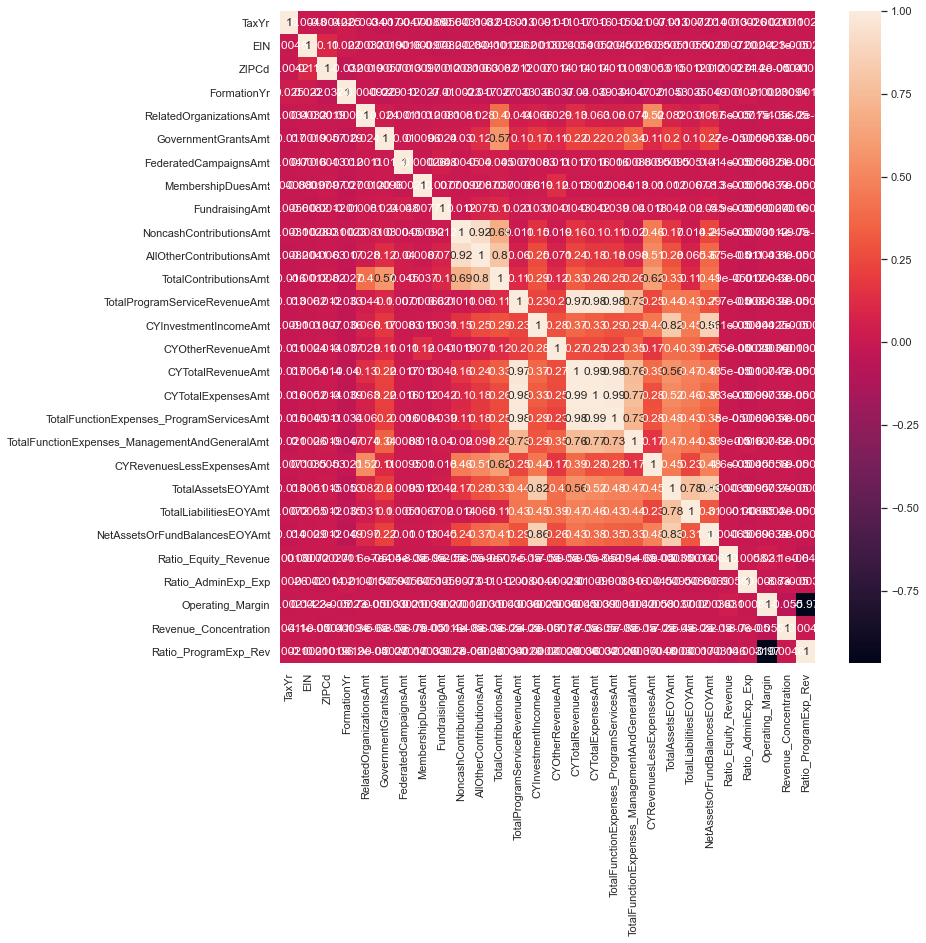

In [36]:
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(df.corr(), annot=True)
plt.show()

# Looking at just the Terminate variable

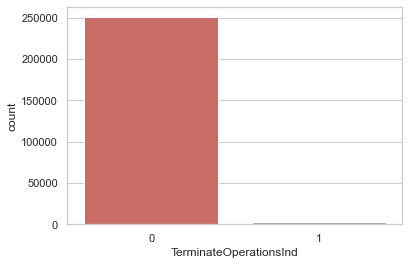

percentage of not terminating 99.06693054913626
percentage of termination 0.933069450863741


In [66]:
sns.countplot(x='TerminateOperationsInd', data = df, palette = 'hls')
plot = sns.countplot(x='TerminateOperationsInd', data = df, palette = 'hls')
figure = plot.get_figure() 
figure.savefig('C:/Users/tenis/OneDrive/Desktop/Data_Projects/Impact_Capital/reports/terminate_countplot.png')
plt.show()

count_no_terminate = len(df[df['TerminateOperationsInd']==0])
count_terminate = len(df[df['TerminateOperationsInd']==1])
pct_of_no_terminate = count_no_terminate/(count_no_terminate+count_terminate)
print("percentage of not terminating", pct_of_no_terminate*100)
pct_of_terminate = count_terminate/(count_no_terminate+count_terminate)
print("percentage of termination", pct_of_terminate*100)

In [67]:
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 1000)
pd.set_option('display.min_rows', 200)

grouped = df.groupby('TerminateOperationsInd').mean()
grouped

,TaxYr,EIN,ZIPCd,FormationYr,RelatedOrganizationsAmt,GovernmentGrantsAmt,FederatedCampaignsAmt,MembershipDuesAmt,FundraisingAmt,NoncashContributionsAmt,AllOtherContributionsAmt,TotalContributionsAmt,TotalProgramServiceRevenueAmt,CYInvestmentIncomeAmt,CYOtherRevenueAmt,CYTotalRevenueAmt,CYTotalExpensesAmt,CYRevenuesLessExpensesAmt,TotalAssetsEOYAmt,TotalLiabilitiesEOYAmt,NetAssetsOrFundBalancesEOYAmt,TypeOfOrganizationCorpInd,TypeOfOrganizationTrustInd,TypeOfOrganizationAssocInd,TypeOfOrganizationOtherInd,SchoolOperatingInd,OperateHospitalInd,AddressChangeInd,InitialReturnInd,AmendedReturnInd,Total_Equity,Ratio_Equity_Revenue
TerminateOperationsInd,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2017.0,4.628458e+08,5.509224e+07,1982.415080,142620.464369,682910.958179,8843.694231,43869.392370,39498.080680,261304.043684,991070.880928,1.908814e+06,7.672708e+06,5.167028e+05,235302.794965,1.033354e+07,9.621563e+06,7.119757e+05,2.272639e+07,9.945669e+06,1.278072e+07,0.887763,0.0,0.044003,0.022721,0.051619,0.009096,0.038436,0.009785,0.008398,1.278072e+07,NaN
1,2017.0,4.483790e+08,5.266077e+07,1989.336436,948233.414056,715338.838273,4129.345047,21057.866215,24961.882303,57341.964014,723813.883573,2.437535e+06,1.479850e+07,1.135805e+06,374693.948349,1.874654e+07,1.755093e+07,1.195606e+06,1.850976e+07,8.208012e+06,1.030175e+07,0.870872,0.0,0.030483,0.030483,0.140559,0.099915,0.117273,0.007197,0.008467,1.030175e+07,NaN


<Figure size 25200x10800 with 0 Axes>

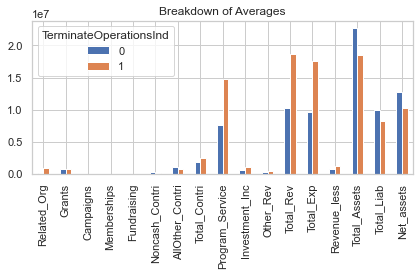

In [64]:
avg_plot = grouped.drop(['TaxYr', 'EIN', 'ZIPCd', 'FormationYr',
                       'TypeOfOrganizationCorpInd','TypeOfOrganizationTrustInd',
                       'TypeOfOrganizationAssocInd', 'TypeOfOrganizationOtherInd',
                       'AddressChangeInd', 'InitialReturnInd', 'AmendedReturnInd',
                        'SchoolOperatingInd', 'OperateHospitalInd'], axis = 1)
list(avg_plot.columns) 
avg_plot = avg_plot.rename(columns={'RelatedOrganizationsAmt' : 'Related_Org', 
                                     'GovernmentGrantsAmt': 'Grants',
                                     'FederatedCampaignsAmt' : 'Campaigns',
                                     'MembershipDuesAmt' : 'Memberships',
                                     'FundraisingAmt' : 'Fundraising',
                                     'NoncashContributionsAmt' : 'Noncash_Contri',
                                     'AllOtherContributionsAmt': 'AllOther_Contri',
                                     'TotalContributionsAmt' : 'Total_Contri',
                                     'TotalProgramServiceRevenueAmt' : 'Program_Service',
                                     'CYInvestmentIncomeAmt':'Investment_Inc',
                                     'CYOtherRevenueAmt' : 'Other_Rev',
                                     'CYTotalRevenueAmt': 'Total_Rev',
                                     'CYTotalExpensesAmt': 'Total_Exp',
                                     'CYRevenuesLessExpensesAmt':'Revenue_less' ,
                                     'TotalAssetsEOYAmt' : 'Total_Assets',
                                     'TotalLiabilitiesEOYAmt':'Total_Liab',
                                     'NetAssetsOrFundBalancesEOYAmt': 'Net_assets'})

# Transpose the columns and index 
avg_plotT = avg_plot.T

#
plt.figure(figsize=(350,150))
ax = avg_plotT.plot.bar(rot=0)
plt.title("Breakdown of Averages")
plt.xticks(rotation='vertical')
plt.tight_layout()
figure = ax.get_figure() 
figure.savefig('C:/Users/tenis/OneDrive/Desktop/Data_Projects/Impact_Capital/reports/average_breakdown.png', dpi = 150)

## Observations from organizations that terminated operations:

* The average age of terminated organizations is 7 years older
* On average terminating organizations rely on related organization revenue 6.5 times as much 
* They rely more on grants 
* Receive half as much from federated campaigns (althoght his number is small in relative terms)
* Receive half as much on membership dues 
* Rely twice as much on programservice revenue 
* No noticeable difference in the type of organization
* Organizations that operate schools and hospitals more likely to terminate organizations

## Because the percentage of nonprofits that declare bankrupcy is pretty low, it doesn't seem to be a good proxy of financial vulenerability. There are also a multitude of reasons why a nonprofit would declare bankrupcy besides just financial vulnerability, such as administrators leaving the organization, certain funding sources being abruptly cut etc)

# Setting up logistic model

In [39]:
from sklearn import preprocessing

logistic = df.drop(['TaxYr',
                    'TaxPeriodBeginDt',
                    'EIN', 'BusinessName',
                    'City',
                    'State',
                    'ZIPCd',
                    'LegalDomicileStateCd',
                    'ActivityOrMissionDesc',
                    'CYRevenuesLessExpensesAmt',
                    'CYTotalRevenueAmt',
                    'TotalLiabilitiesEOYAmt',
                    'NetAssetsOrFundBalancesEOYAmt',
                    'TotalContributionsAmt',
                   'CYTotalExpensesAmt',
                    'TotalAssetsEOYAmt',
                   'TypeOfOrganizationTrustInd'], axis =1)

#Apparently no trust in this dataset. 
logistic = logistic.fillna(0)


X = logistic.loc[:, logistic.columns != 'TerminateOperationsInd']
X_colnames = X.columns
#normalizeing
X = preprocessing.normalize(X)
X = pd.DataFrame(X, columns = X_colnames)
y = logistic.loc[:, logistic.columns == 'TerminateOperationsInd']

#In order to over sample terminated nonprofits i'll be using SMOTE
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['TerminateOperationsInd'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of terminated nonprofits in oversampled data",len(os_data_y[os_data_y['TerminateOperationsInd']==1]))
print("Number of surviving nonprofits",len(os_data_y[os_data_y['TerminateOperationsInd']==0]))
print("Proportion of terminated nonprofit data in oversampled data is ",len(os_data_y[os_data_y['TerminateOperationsInd']==1])/len(os_data_X))
print("Proportion of surviving nonprofit data in oversampled data is ",len(os_data_y[os_data_y['TerminateOperationsInd']==0])/len(os_data_X))

length of oversampled data is  351150
Number of terminated nonprofits in oversampled data 175575
Number of surviving nonprofits 175575
Proportion of terminated nonprofit data in oversampled data is  0.5
Proportion of surviving nonprofit data in oversampled data is  0.5


In [40]:
#Recursive Feature Elimination
data_final_vars=logistic.columns.values.tolist()
y=['TerminateOperationsInd']
X=[i for i in data_final_vars if i not in y]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter = 1000)
rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

C:\Users\tenis\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [59]:
mask = rfe.support_
mask = mask.tolist()
mask.append(False)
cols = logistic.loc[:, mask]
#I had to select these variables to get it to work
cols = cols[['FormationYr', 'GovernmentGrantsAmt', 'TypeOfOrganizationCorpInd', 'TypeOfOrganizationAssocInd','TypeOfOrganizationOtherInd', 'SchoolOperatingInd']]
cols = cols.columns

In [61]:
X=os_data_X[cols]
y=os_data_y['TerminateOperationsInd']

In [62]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit(maxiter = 200)
print(result.summary2())

C:\Users\tenis\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: inf
         Iterations: 200


C:\Users\tenis\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


LinAlgError: Singular matrix

In [6]:
bind = pd.read_csv('C:/Users/Administrator/Desktop/Impact_Capital/data/objects/2018_objects.csv')

bind.append(pd.read_csv('C:/Users/Administrator/Desktop/Impact_Capital/data/objects/2019_objects.csv'), ignore_index=True)
bind.append(pd.read_csv('C:/Users/Administrator/Desktop/Impact_Capital/data/objects/2020_objects.csv'), ignore_index=True)

,Unnamed: 0,Object_ID,TaxYr,TaxPeriodBeginDt,EIN,BusinessName,City,State,ZIPCd,FormationYr,...,TypeOfOrganizationAssocInd,TypeOfOrganizationOtherInd,SchoolOperatingInd,OperateHospitalInd,AddressChangeInd,InitialReturnInd,AmendedReturnInd,FinalReturnInd,TerminateOperationsInd,schedule0
0,0,2018201800089349300000,2016,2016-07-01,204852205,OCEAN HOUSING DEVELOPMENT III INC,BAYVILLE,NJ,8721.0,2008.0,...,NaN,NaN,false,false,X,NaN,NaN,NaN,false,{'{http://www.irs.gov/efile}SupplementalInform...
1,0,2018201800089349300005,2016,2016-08-01,930561977,United Association Local 290 Apprentice and,tualatin,OR,97062.0,1985.0,...,NaN,NaN,{'referenceDocumentId': 'IRS990ScheduleE'},false,NaN,NaN,NaN,NaN,false,"{'documentId': 'IRS990ScheduleO', '{http://www..."
2,0,2018201800089349300010,2016,2016-09-01,270607115,MARION CHAMBER OF COMMERCE,MARION,IA,52302.0,2009.0,...,NaN,NaN,false,false,NaN,NaN,NaN,NaN,false,{'{http://www.irs.gov/efile}SupplementalInform...
3,0,2018201800089349300015,2016,2016-07-01,371173814,THE GLEN-ED PANTRY,EDWARDSVILLE,IL,62025.0,1993.0,...,NaN,NaN,false,false,NaN,NaN,NaN,NaN,false,{'{http://www.irs.gov/efile}SupplementalInform...
4,0,2018201800089349300020,2016,2016-07-01,30353976,SOUTHEAST VERMONT TRANSIT INC,WEST DOVER,VT,5356.0,1996.0,...,NaN,NaN,0,0,NaN,NaN,NaN,NaN,0,{'{http://www.irs.gov/efile}SupplementalInform...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335132,0,2020202042409349300314,2019,2019-01-01,463236114,SECOND CHANCE THROUGH FAITH,Colorado Springs,CO,80916.0,2013.0,...,NaN,NaN,false,false,NaN,NaN,NaN,NaN,false,{'{http://www.irs.gov/efile}SupplementalInform...
335133,0,2020202042409349300319,2019,2019-01-01,815421929,PICKLEPLEX OF PUNTA GORDA INC,PUNTA GORDA,FL,33951.0,2017.0,...,NaN,NaN,false,false,NaN,NaN,NaN,NaN,false,{'{http://www.irs.gov/efile}SupplementalInform...
335134,0,2020202042409349300324,2019,2019-01-01,205090246,GREEN ELECTRONICS COUNCIL,PORTLAND,OR,97212.0,2006.0,...,NaN,NaN,0,0,X,NaN,NaN,NaN,0,{'{http://www.irs.gov/efile}SupplementalInform...
335135,0,2020202042409349300334,2018,2018-10-01,300087390,Pine Hills Inc,McComb,MS,39648.0,2002.0,...,NaN,NaN,0,0,NaN,NaN,NaN,NaN,0,{'{http://www.irs.gov/efile}SupplementalInform...


In [7]:
bind.to_csv('form_990_objects_2018_2020.csv', index = False)